In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# ----------------------------
# Loading the data
# ----------------------------

# tour_logs_train.csv
url = "https://drive.google.com/file/d/15aGNYt1rgVhxf4Nzoi1TLg-javvqQy58/view?usp=drive_link"
file_id = "15aGNYt1rgVhxf4Nzoi1TLg-javvqQy58"
direct_download_url = f"https://drive.google.com/uc?export=download&id={file_id}"
data = pd.read_csv(direct_download_url)

# Information that could be known before the show:
# 1. Show_DateTime 2. Day_of_Week 3. Ticket_Price 4. Moon_Phase 5. Band_Outfit 6. Venue_ID

# Factors that could possibly influence the crowd energy:
# 1. Time of show 2. Day_of_Week 3. Ticket_Price 4. Volume_Level 5. Band_Outfit 6. Venue_ID

# copy of data for EDA
clean_data = data.copy()

# ----------------------------
# Preprocessing of data
# ----------------------------

# Taking only the important columns that are needed for training the model
train_data = data[['Show_DateTime', 'Day_of_Week', 'Ticket_Price', 'Band_Outfit', 'Venue_ID', 'Crowd_Energy', 'Volume_Level']].copy()

### CLEANING OF DATA
## deleting the entries which have faulty value of Crowd_Energy (rows remained = 1992)
train_data = train_data[(train_data.Crowd_Energy >= 0) & (train_data.Crowd_Energy <= 100)]
clean_data = clean_data[(clean_data.Crowd_Energy >= 0) & (clean_data.Crowd_Energy <= 100)]

## Date and Time
# Handling the invalid dates and dates which were invalid in format
train_data['Show_DateTime'] = pd.to_datetime(train_data['Show_DateTime'], infer_datetime_format=True, errors="coerce")
clean_data['Show_DateTime'] = pd.to_datetime(clean_data['Show_DateTime'], infer_datetime_format=True, errors="coerce")

## Ticket_Price
def clean_price(x):
  if pd.isna(x):
    return np.nan

  x = str(x).strip()

  if x.lower() == 'free':
    return 0.0

  # Detect currency
  if '£' in x:
    rate = 1.27
  elif '€' in x:
    rate = 1.09
  else:
    rate = 1.0

  # This handles the entries where VIP price is also given (only the first price is extracted)
  # Only the general prices are taken as they will impact the Crowd_Energy the most and no the VIP prices
  match = re.search(r'(\d+(\.\d+)?)', x)
  if match:
    return float(match.group(1)) * rate

  return np.nan

train_data['clean_Ticket_Price'] = train_data['Ticket_Price'].apply(clean_price)
clean_data['Ticket_Price'] = clean_data['Ticket_Price'].apply(clean_price)

train_data = train_data[train_data.clean_Ticket_Price >= 0]
clean_data = clean_data[clean_data.Ticket_Price >= 0]

## Day of Week
train_data = train_data[train_data['Day_of_Week'].isin(range(7))]
clean_data = clean_data[clean_data['Day_of_Week'].isin(range(7))]

## Volume level
train_data = train_data[(train_data['Volume_Level'] > 0) & (train_data['Volume_Level'] <= 11)]
clean_data = clean_data[(clean_data['Volume_Level'] > 0) & (clean_data['Volume_Level'] <= 11)]

## Crowd size
clean_data.loc[(clean_data.Crowd_Size <= 0) | (clean_data.Crowd_Size > 1000), 'Crowd_Size'] = np.nan

# separating the dependant and independant variables
y = train_data.pop('Crowd_Energy')
x = train_data.copy()

# The date and time are not included for model training because there are many discrpencies in the format
cleaned_DateTime = x.pop('Show_DateTime')


### ENCODING PROCESS For Day_of_Week
# Acc to the encoding Mon=0,Tue=1....
weekend_days = [5,6]

# Classifying the Days_of_Week as either weekend or not
x['is_weekend'] = x['Day_of_Week'].apply(lambda x: 1 if x in weekend_days else 0)

# Drop original Day_of_Week and Ticket_Price columns
x.drop(columns=['Ticket_Price', 'Day_of_Week'], inplace=True)


## splitting the train and test data sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


### ENCODING PROCESS For Venue_ID and Band_Outfit

## Venue_ID
venue_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# FIT on training data ONLY
venue_encoder.fit(x_train[['Venue_ID']])
# Transform
x_train_venue = venue_encoder.transform(x_train[['Venue_ID']])
x_test_venue   = venue_encoder.transform(x_test[['Venue_ID']])

# Convert to DataFrame with proper column names
venue_cols = venue_encoder.get_feature_names_out(['Venue_ID'])
x_train_venue_df = pd.DataFrame(x_train_venue, columns=venue_cols, index=x_train.index)
x_test_venue_df = pd.DataFrame(x_test_venue, columns=venue_cols, index=x_test.index)

# Drop original Band_Outfit and Add encoded outfit columns
x_train = pd.concat([x_train.drop(columns=['Venue_ID']), x_train_venue_df], axis=1)
x_test = pd.concat([x_test.drop(columns=['Venue_ID']), x_test_venue_df], axis=1)


## Band_Outfit
outfit_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# FIT only on training data
outfit_encoder.fit(x_train[['Band_Outfit']])
# Transform
x_train_outfit = outfit_encoder.transform(x_train[['Band_Outfit']])
x_test_outfit = outfit_encoder.transform(x_test[['Band_Outfit']])

# Convert to DataFrame with proper column names
outfit_cols = outfit_encoder.get_feature_names_out(['Band_Outfit'])
x_train_outfit_df = pd.DataFrame(x_train_outfit, columns=outfit_cols, index=x_train.index)
x_test_outfit_df = pd.DataFrame(x_test_outfit, columns=outfit_cols, index=x_test.index)

# Drop original Band_Outfit and Add encoded outfit columns
x_train = pd.concat([x_train.drop(columns=['Band_Outfit']), x_train_outfit_df], axis=1)
x_test = pd.concat([x_test.drop(columns=['Band_Outfit']), x_test_outfit_df], axis=1)


/tmp/ipython-input-260961800.py:46: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  train_data['Show_DateTime'] = pd.to_datetime(train_data['Show_DateTime'], infer_datetime_format=True, errors="coerce")
/tmp/ipython-input-260961800.py:47: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  clean_data['Show_DateTime'] = pd.to_datetime(clean_data['Show_DateTime'], infer_datetime_format=True, errors="coerce")


#Justification for choice of model

I have applied the **Random Forest Regression model** for this purpose because it handles non-linear relations well and also handles one-hot encoding properly. They are simple to train and can be generalised easily for other test data. Moreover, they are robust to noise which in this case is helpful.



In [21]:
# -----------------------------------------------------------
# Training of model on train data and tuning Hyperparameters
# -----------------------------------------------------------

## The Random Forest Regression model

# This is the default model which runs with default values of hyperparameters
model_default = RandomForestRegressor(n_estimators=100, criterion='squared_error', random_state=None, n_jobs=None, max_depth=None)

# This model was overfitting the train data, so further efforts were to decrease the overfitting


# Tuning Hyperparameters using cross validation

The tuning for hyper-parameters was done using the Cross Validation method, in particular, 5-fold Cross Validation was used which trained and tested 300 fits.

The explored value of parameters are:

*   n_estimators : [200, 400, 600]
*   max_depth : [1, 3, 5, 7, 9]
*   min_samples_leaf : [1, 2, 5, 20]

Other parameters such as n_jobs and random_state were chosen to maximise efficency and get consistency.

In [22]:
# -----------------------------------------------
# Tuning Hyperparameters using cross validation
# -----------------------------------------------

# Define model
model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Define hyperparameter grid
parameter_grid = {'n_estimators': [200, 400, 600], 'max_depth': [x for x in range(1,11,2)], 'min_samples_leaf': [1, 2, 5, 10]}

# Grid Search with 5 Fold Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=parameter_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1, refit=True)

# Run grid search
grid_search.fit(x_train, y_train)

# -----------------------------------------
# Final model with tuned Hyperparameters
# -----------------------------------------

tuned_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# Un-comment these to see the parameters of tuned_model and the best score of model
# print("Best Parameters:", best_params)
# print("Best CV RMSE:", best_score)

# Fitting the model on the whole of training data
x_full = pd.concat([x_train, x_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)
tuned_model.fit(x_full, y_full)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomForestRegressor(max_depth=5, min_samples_leaf=10, n_estimators=600,
                      n_jobs=-1, random_state=42)

Code for applying the trained model on the test data

The preprocessing step is same as before. The predictions of the test data are then exported to a csv file.

In [23]:
# ----------------------------
# Loading the data
# ----------------------------

# tour_logs_test_input.csv
url = "https://drive.google.com/file/d/1sNw7CRVwAWkgW0-9Nv-1u4p2jkseBClJ/view?usp=drive_link"
file_id = "15aGNYt1rgVhxf4Nzoi1TLg-javvqQy58"
direct_download_url = f"https://drive.google.com/uc?export=download&id={file_id}"
data = pd.read_csv(direct_download_url)

# Information that could be known before the show
# 1. Show_DateTime 2. Day_of_Week 3. Ticket_Price 4. Moon_Phase 5. Band_Outfit 6. Venue_ID

# ----------------------------
# Preprocessing of data
# ----------------------------
test_data = data[['Day_of_Week', 'Ticket_Price', 'Band_Outfit', 'Venue_ID', 'Volume_Level']].copy()

gig_id = data['Gig_ID']

### Cleaning of data

## Show_DateTime
# The date and time are not included for model training because there are many discrpencies in the format

## Ticket_Price
test_data['clean_Ticket_Price'] = test_data['Ticket_Price'].apply(clean_price)
test_data.loc[test_data.clean_Ticket_Price < 0, 'clean_Ticket_Price'] = np.nan

## Day of Week
test_data.loc[~(test_data.Day_of_Week.isin(range(7))), 'Day_of_Week'] = np.nan

## Volume Level
test_data.loc[(test_data['Volume_Level'] > 0) & (test_data['Volume_Level'] <= 11), 'Volume_Level'] = np.nan


x = test_data.copy()


### Encoding Process for Venue_ID, Band_Outfit and Day_of_Week

## Day of Week
# Acc to the encoding Mon=0,Tue=1....
weekend_days = [5,6]

# Classifying the Days_of_Week as either weekend or not
x['is_weekend'] = x['Day_of_Week'].apply(lambda x: 1 if x in weekend_days else 0)

# Drop original Day_of_Week and Ticket_Price columns
x.drop(columns=['Ticket_Price', 'Day_of_Week'], inplace=True)


## Venue_ID
x_venue = venue_encoder.transform(x[['Venue_ID']])
x_venue_df = pd.DataFrame(x_venue, columns=venue_encoder.get_feature_names_out(['Venue_ID']), index=x.index)
x = pd.concat([x.drop(columns=['Venue_ID']), x_venue_df], axis=1)

## Band_Outfit
x_outfit = outfit_encoder.transform(x[['Band_Outfit']])
x_outfit_df = pd.DataFrame(x_outfit, columns=outfit_encoder.get_feature_names_out(['Band_Outfit']), index=x.index)
x = pd.concat([x.drop(columns=['Band_Outfit']), x_outfit_df], axis=1)


# -----------------------------
# Predicting the crowd energy
# -----------------------------

x = x.reindex(columns=x_train.columns, fill_value=0)

# predicting the outcomes
crowd_energy_pred =  tuned_model.predict(x)
prediction = pd.DataFrame({'Gig_ID': gig_id, 'Crowd_Energy': crowd_energy_pred})

prediction.to_csv("prediction.csv", index=False)


#Exploratory Data Analysis

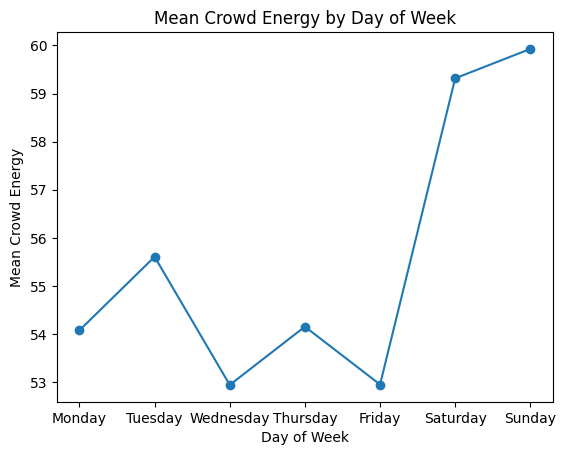

"\nThe line graph clearly shows that the mean crowd energy for Tuesday is not that less, even it is higher then Wednesday and Thursday.\nThough it's less than that for weekend days, but this certainly denies the singer's hypothesis regading tuesday shows.\n\nAlso the weekend shows were most energetic as was expected by intution.\n"

In [24]:
df = clean_data.copy()
#display(df)

# THE TUESDAY CURSE
mean_energy = df.groupby('Day_of_Week')['Crowd_Energy'].mean()

plt.plot( np.arange(7), mean_energy, marker='o')
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(np.arange(7), days, fontsize=10)
plt.xlabel('Day of Week')
plt.ylabel('Mean Crowd Energy')
plt.title('Mean Crowd Energy by Day of Week')
plt.show()

"""
The line graph clearly shows that the mean crowd energy for Tuesday is not that less, even it is higher then Wednesday and Thursday.
Though it's less than that for weekend days, but this certainly denies the singer's hypothesis regading tuesday shows.

Also the weekend shows were most energetic as was expected by intution.
"""

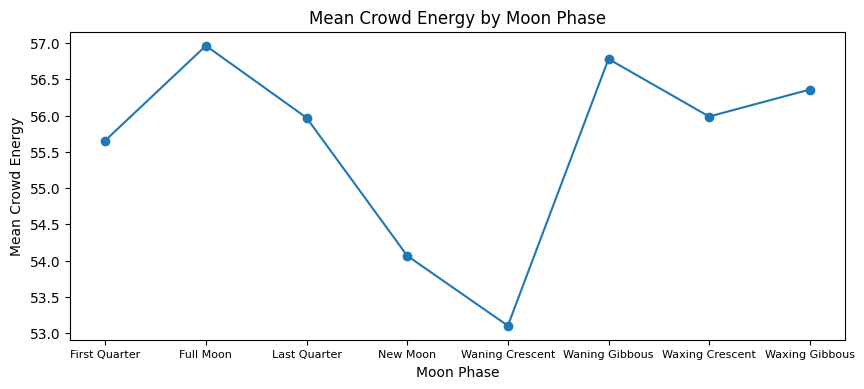

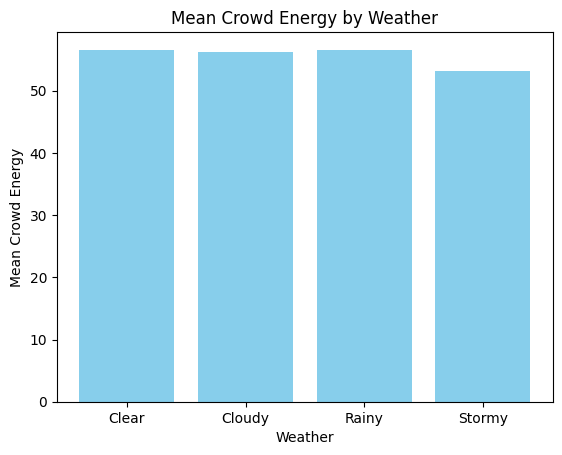

"\nClearly Rainy shows have the highest mean_energy as compared to any other weather.\nSo this discards the singer's hypothesis regarding rain.\n"

In [25]:
# FULL MOON = MAGIC
mean_energy = df.groupby('Moon_Phase')['Crowd_Energy'].mean()
#print(mean_energy)

plt.figure(figsize=(10, 4))
plt.plot( np.arange(len(df.Moon_Phase.unique())), mean_energy, marker='o')
phase = ['First Quarter','Full Moon', 'Last Quarter', 'New Moon', 'Waning Crescent', 'Waning Gibbous', 'Waxing Crescent', 'Waxing Gibbous']
plt.xticks(np.arange(len(df.Moon_Phase.unique())), phase, fontsize=8)
plt.xlabel('Moon Phase')
plt.ylabel('Mean Crowd Energy')
plt.title('Mean Crowd Energy by Moon Phase')
plt.show()

"""
The line chart clearly shows that mean_energy on full moon shows were not energy-loaded instead they were in middle range in the groupings of phases.
So clearly this observation is also not correct.

Also it is noticed that the both Waxing phases were one of highest energy show nights.
"""

# Rain sucks
weather = df.groupby('Weather')['Crowd_Energy'].mean()
#print(weather)

plt.bar(weather.index, weather, align='center', color='skyblue')
plt.xlabel('Weather')
plt.ylabel('Mean Crowd Energy')
plt.title('Mean Crowd Energy by Weather')
plt.show()

"""
Clearly Rainy shows have the highest mean_energy as compared to any other weather.
So this discards the singer's hypothesis regarding rain.
"""


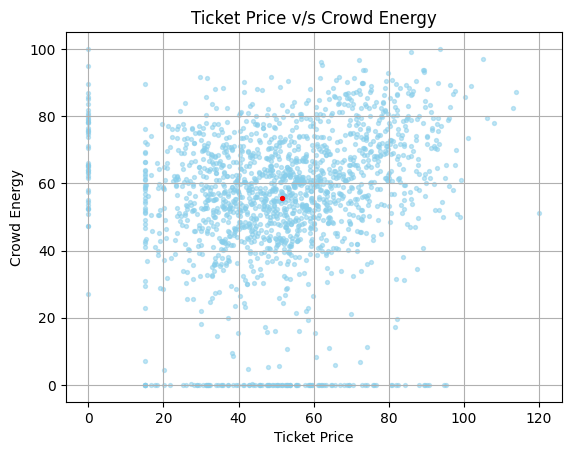

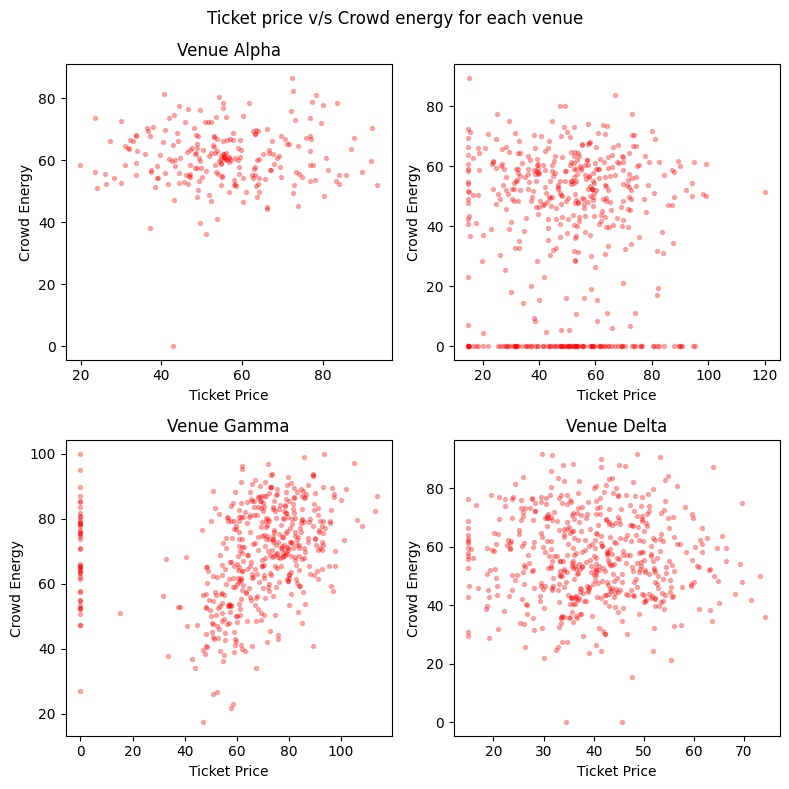

"\nThe Snob pit is price sensitive as there is a clear uptrend in crowd energy for this venue.\nAll other venue are relatively price neutral as they have horizontal spread of points.\nThe Vampire's Den could be called the energy sink as it has the most number of zero-energy shows.\n"

In [26]:
venues = df.groupby('Venue_ID')

# Sweet spot
mean_price = df['Ticket_Price'].mean()
mean_energy = df['Crowd_Energy'].mean()
plt.scatter(df['Ticket_Price'], df['Crowd_Energy'], s=8, alpha=0.5, c='skyblue')
plt.scatter([mean_price], [mean_energy], c='red', s=8)    # the average point
plt.grid()
plt.xlabel('Ticket Price')
plt.ylabel('Crowd Energy')
plt.title('Ticket Price v/s Crowd Energy')
plt.show()

"""
From graph its clear that crowd energy tend to increase with increase in ticket price. The free tickets also do not ensure that energy will be high.
The proportion of low energy shows also decrease with increase in ticket price, with most of low-energy shows in the medium price range.

The points in medium price range are concentrated near the average_energy point whereas those for high priced shows are spread out but stil above the average.
So the sweet spot for price could be in the $70 - $100 range.
"""

# Ticket price v/s Crowd energy for each venue
fig, ax = plt.subplots(2,2, figsize=(8,8))

fig.suptitle('Ticket price v/s Crowd energy for each venue')
ax[0,0].scatter(venues.get_group('V_Alpha')['Ticket_Price'], venues.get_group('V_Alpha')['Crowd_Energy'], s=8, alpha=0.3, c='red')
ax[0,0].set_xlabel('Ticket Price')
ax[0,0].set_ylabel('Crowd Energy')
ax[0,0].set_title('Venue Alpha')
ax[0,1].scatter(venues.get_group('V_Beta')['Ticket_Price'], venues.get_group('V_Beta')['Crowd_Energy'], s=8, alpha=0.3, c='red')
ax[0,1].set_xlabel('Ticket Price')
ax[0,1].set_ylabel('Crowd Energy')
ax[1,0].set_title('Venue Beta')
ax[1,0].scatter(venues.get_group('V_Gamma')['Ticket_Price'], venues.get_group('V_Gamma')['Crowd_Energy'], s=8, alpha=0.3, c='red')
ax[1,0].set_xlabel('Ticket Price')
ax[1,0].set_ylabel('Crowd Energy')
ax[1,0].set_title('Venue Gamma')
ax[1,1].scatter(venues.get_group('V_Delta')['Ticket_Price'], venues.get_group('V_Delta')['Crowd_Energy'], s=8, alpha=0.3, c='red')
ax[1,1].set_xlabel('Ticket Price')
ax[1,1].set_ylabel('Crowd Energy')
ax[1,1].set_title('Venue Delta')
plt.tight_layout()
plt.show()

"""
The Snob pit is price sensitive as there is a clear uptrend in crowd energy for this venue.
All other venue are relatively price neutral as they have horizontal spread of points.
The Vampire's Den could be called the energy sink as it has the most number of zero-energy shows.
"""

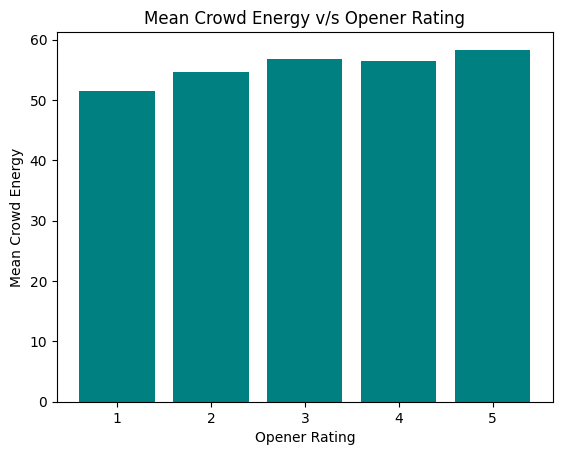

'\nYes the opener rating clearly shows that a good opening is also a sign of more energetic crowd.\nSo, the singer is correct with this observation.\n'

In [27]:
# The Opener Guy
open = df.groupby('Opener_Rating')

plt.bar(np.arange(1,6), open['Crowd_Energy'].mean(), align='center', color='teal')
plt.xlabel('Opener Rating')
plt.ylabel('Mean Crowd Energy')
plt.title('Mean Crowd Energy v/s Opener Rating')
plt.show()
"""
Yes the opener rating clearly shows that a good opening is also a sign of more energetic crowd.
So, the singer is correct with this observation.
"""

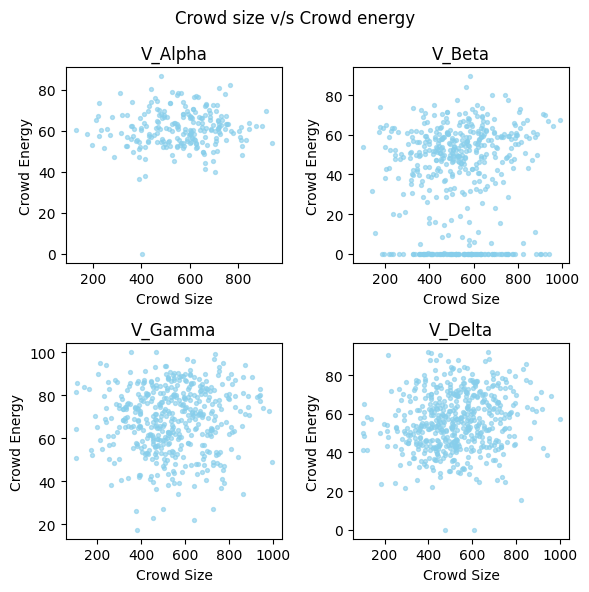

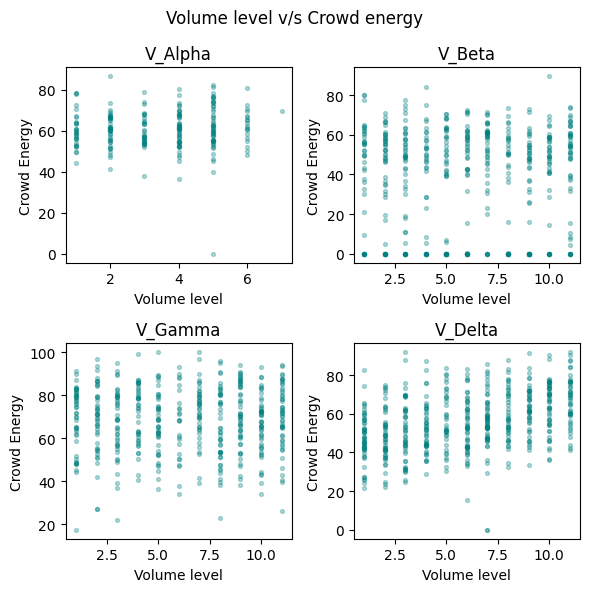

'\nThere is no venue where we can infer that the crowd itself feeds energy as no venue shows clear uptrend in crowd energy with increase in crowd_size.\n\nAt V_Delta there is an upward movement of points showing that crowd energy tend to be more for higher volume levels.\n'

In [28]:


# The crowd feeds itself
fig, ax = plt.subplots(2, 2, figsize=(6,6))
fig.suptitle('Crowd size v/s Crowd energy')
ax[0,0].scatter(venues.get_group('V_Alpha')['Crowd_Size'], venues.get_group('V_Alpha')['Crowd_Energy'], s=8, alpha=0.6, c='skyblue')
ax[0,0].set_xlabel('Crowd Size')
ax[0,0].set_ylabel('Crowd Energy')
ax[0,0].set_title('V_Alpha')
ax[0,1].scatter(venues.get_group('V_Beta')['Crowd_Size'], venues.get_group('V_Beta')['Crowd_Energy'], s=8, alpha=0.6, c='skyblue')
ax[0,1].set_xlabel('Crowd Size')
ax[0,1].set_ylabel('Crowd Energy')
ax[0,1].set_title('V_Beta')
ax[1,0].scatter(venues.get_group('V_Gamma')['Crowd_Size'], venues.get_group('V_Gamma')['Crowd_Energy'], s=8, alpha=0.6, c='skyblue')
ax[1,0].set_xlabel('Crowd Size')
ax[1,0].set_ylabel('Crowd Energy')
ax[1,0].set_title('V_Gamma')
ax[1,1].scatter(venues.get_group('V_Delta')['Crowd_Size'], venues.get_group('V_Delta')['Crowd_Energy'], s=8, alpha=0.6, c='skyblue')
ax[1,1].set_xlabel('Crowd Size')
ax[1,1].set_ylabel('Crowd Energy')
ax[1,1].set_title('V_Delta')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(6,6))
fig.suptitle('Volume level v/s Crowd energy')
ax[0,0].scatter(venues.get_group('V_Alpha')['Volume_Level'], venues.get_group('V_Alpha')['Crowd_Energy'], s=8, alpha=0.3, c='teal')
ax[0,0].set_xlabel('Volume level')
ax[0,0].set_ylabel('Crowd Energy')
ax[0,0].set_title('V_Alpha')
ax[0,1].scatter(venues.get_group('V_Beta')['Volume_Level'], venues.get_group('V_Beta')['Crowd_Energy'], s=8, alpha=0.3, c='teal')
ax[0,1].set_xlabel('Volume level')
ax[0,1].set_ylabel('Crowd Energy')
ax[0,1].set_title('V_Beta')
ax[1,0].scatter(venues.get_group('V_Gamma')['Volume_Level'], venues.get_group('V_Gamma')['Crowd_Energy'], s=8, alpha=0.3, c='teal')
ax[1,0].set_xlabel('Volume level')
ax[1,0].set_ylabel('Crowd Energy')
ax[1,0].set_title('V_Gamma')
ax[1,1].scatter(venues.get_group('V_Delta')['Volume_Level'], venues.get_group('V_Delta')['Crowd_Energy'], s=8, alpha=0.3, c='teal')
ax[1,1].set_xlabel('Volume level')
ax[1,1].set_ylabel('Crowd Energy')
ax[1,1].set_title('V_Delta')
plt.tight_layout()
plt.show()

"""
There is no venue where we can infer that the crowd itself feeds energy as no venue shows clear uptrend in crowd energy with increase in crowd_size.

At V_Delta there is an upward movement of points showing that crowd energy tend to be more for higher volume levels.
"""

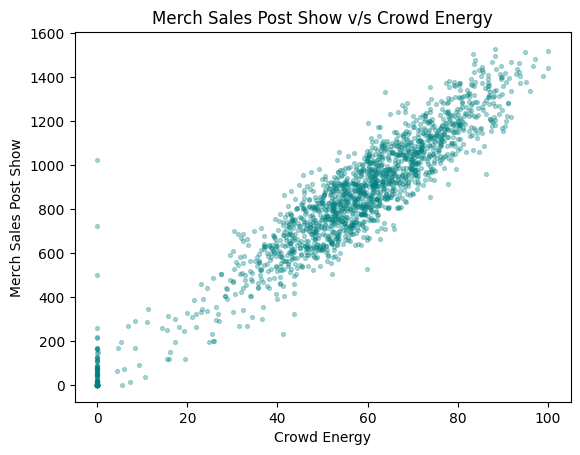

'\nThis is surely a correct observation that more crowd energy leads to more merch sales post show.\n'

In [29]:
# Post-show sales

plt.scatter(df.Crowd_Energy, df.Merch_Sales_Post_Show, s=8, alpha=0.3, c='teal')
plt.xlabel('Crowd Energy')
plt.ylabel('Merch Sales Post Show')
plt.title('Merch Sales Post Show v/s Crowd Energy')
plt.show()

"""
This is surely a correct observation that more crowd energy leads to more merch sales post show.
"""